In [ ]:
import xgboost as xgb; 
print(xgb.__version__)

1.6.2


In [52]:
import os
import glob
import pandas as pd
import pickle
#import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import model_inference


In [2]:
# Build a .py script that takes a snapshot date, loads a model artefact and make an inference and save to datamart

## set up pyspark session

In [53]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## set up config

In [ ]:
import datetime
import os

start_date = datetime.date(2017, 1, 1)
end_date = datetime.date(2018, 10, 1)

modelname = 'reg_2018_04_01.pkl'

for i in range((end_date - start_date).days + 1):
    day = start_date + datetime.timedelta(days=i)
    day_str = day.strftime("%Y-%m-%d")
    cmd = f'python model_inference.py --snapshotdate "{day_str}" --modelname "{modelname}"'
    print(f'execute command: {cmd}')
    os.system(cmd)

execute command: python model_inference.py --snapshotdate "2017-01-01" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:34:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:34:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:34:19 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 1, 0, 0),
 'snapshot_date_str': '2017-01-01'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl
y_inference 0
datamart/gold/model_predictions/reg_2018_04_01/
No inference data to write. Skipping write step.


Saving labels: 100%|██████████| 1/1 [00:00<00:00, 484.95it/s]




---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-02" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:34:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:34:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:34:23 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 2, 0, 0),
 'snapshot_date_str': '2017-01-02'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl
y_inference 0
datamart/gold/model_predictions/reg_2018_04_01/
No inference data to write. Skipping write step.


Saving labels: 100%|██████████| 1/1 [00:00<00:00, 526.33it/s]




---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-03" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:34:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:34:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:34:27 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 3, 0, 0),
 'snapshot_date_str': '2017-01-03'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl
y_inference 0
datamart/gold/model_predictions/reg_2018_04_01/
No inference data to write. Skipping write step.


---completed job---




Saving labels: 100%|██████████| 1/1 [00:00<00:00, 491.89it/s]


execute command: python model_inference.py --snapshotdate "2017-01-04" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:34:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:34:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:34:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 4, 0, 0),
 'snapshot_date_str': '2017-01-04'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels: 100%|██████████| 1/1 [00:00<00:00, 521.42it/s]


y_inference 0
datamart/gold/model_predictions/reg_2018_04_01/
No inference data to write. Skipping write step.


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-05" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:34:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:34:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:34:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 5, 0, 0),
 'snapshot_date_str': '2017-01-05'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


X_inference 32
num of rows add:32
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_05.parquet
rows added: 32


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-06" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:34:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:34:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:34:44 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 6, 0, 0),
 'snapshot_date_str': '2017-01-06'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


X_inference 4
num of rows add:4
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_06.parquet
rows added: 4


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-07" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:34:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:34:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:34:52 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 7, 0, 0),
 'snapshot_date_str': '2017-01-07'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


X_inference 4
num of rows add:4
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_07.parquet
rows added: 4


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-08" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:35:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:35:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:35:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 8, 0, 0),
 'snapshot_date_str': '2017-01-08'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


X_inference 4
num of rows add:4
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_08.parquet
rows added: 4


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-09" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:35:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:35:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:35:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 9, 0, 0),
 'snapshot_date_str': '2017-01-09'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


X_inference 5
num of rows add:5
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_09.parquet
rows added: 5


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-10" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:35:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:35:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:35:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 10, 0, 0),
 'snapshot_date_str': '2017-01-10'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


X_inference 6
num of rows add:6
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_10.parquet
rows added: 6


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-11" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:35:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:35:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:35:26 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 11, 0, 0),
 'snapshot_date_str': '2017-01-11'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


X_inference 10
num of rows add:10
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_11.parquet
rows added: 10


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-12" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:35:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:35:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:35:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 12, 0, 0),
 'snapshot_date_str': '2017-01-12'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


X_inference 12
num of rows add:12
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_12.parquet
rows added: 12


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-13" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:35:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:35:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:35:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 13, 0, 0),
 'snapshot_date_str': '2017-01-13'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


X_inference 10
num of rows add:10
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_13.parquet
rows added: 10


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-14" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:35:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:35:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:35:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 14, 0, 0),
 'snapshot_date_str': '2017-01-14'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


X_inference 16
num of rows add:16
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_14.parquet
rows added: 16


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-15" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:36:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:36:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:36:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 15, 0, 0),
 'snapshot_date_str': '2017-01-15'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


X_inference 14
num of rows add:14
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_15.parquet
rows added: 14


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-16" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:36:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:36:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:36:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 16, 0, 0),
 'snapshot_date_str': '2017-01-16'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


X_inference 18
num of rows add:18
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_16.parquet
rows added: 18


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-17" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:36:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:36:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:36:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 17, 0, 0),
 'snapshot_date_str': '2017-01-17'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


X_inference 32
num of rows add:32
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_17.parquet
rows added: 32


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-18" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:36:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:36:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:36:27 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 18, 0, 0),
 'snapshot_date_str': '2017-01-18'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


X_inference 30
num of rows add:30
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_18.parquet
rows added: 30


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-19" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:36:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:36:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:36:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 19, 0, 0),
 'snapshot_date_str': '2017-01-19'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


X_inference 29
num of rows add:29
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_19.parquet
rows added: 29


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-20" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:36:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:36:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:36:44 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 20, 0, 0),
 'snapshot_date_str': '2017-01-20'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


X_inference 28
num of rows add:28
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_20.parquet
rows added: 28


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-21" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:36:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:36:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:36:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 21, 0, 0),
 'snapshot_date_str': '2017-01-21'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


X_inference 22
num of rows add:22
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_21.parquet
rows added: 22


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-22" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:37:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:37:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:37:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 22, 0, 0),
 'snapshot_date_str': '2017-01-22'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


X_inference 30
num of rows add:30
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_22.parquet
rows added: 30


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-23" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:37:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:37:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:37:13 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 23, 0, 0),
 'snapshot_date_str': '2017-01-23'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


X_inference 36
num of rows add:36
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_23.parquet
rows added: 36


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-24" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:37:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:37:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:37:21 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 24, 0, 0),
 'snapshot_date_str': '2017-01-24'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


X_inference 38
num of rows add:38
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_24.parquet
rows added: 38


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-25" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:37:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:37:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:37:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 25, 0, 0),
 'snapshot_date_str': '2017-01-25'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


X_inference 57
num of rows add:57
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_25.parquet
rows added: 57


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-26" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:37:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:37:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:37:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 26, 0, 0),
 'snapshot_date_str': '2017-01-26'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


X_inference 82
num of rows add:82
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_26.parquet
rows added: 82


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-27" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:37:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:37:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:37:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 27, 0, 0),
 'snapshot_date_str': '2017-01-27'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


X_inference 59
num of rows add:59
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_27.parquet
rows added: 59


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-28" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:37:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:37:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:37:55 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 28, 0, 0),
 'snapshot_date_str': '2017-01-28'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


X_inference 28
num of rows add:28
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_28.parquet
rows added: 28


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-29" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:38:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:38:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:38:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 29, 0, 0),
 'snapshot_date_str': '2017-01-29'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


X_inference 31
num of rows add:31
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_29.parquet
rows added: 31


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-30" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:38:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:38:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:38:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 30, 0, 0),
 'snapshot_date_str': '2017-01-30'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


X_inference 48
num of rows add:48
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_30.parquet
rows added: 48


---completed job---


execute command: python model_inference.py --snapshotdate "2017-01-31" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:38:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:38:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:38:21 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 31, 0, 0),
 'snapshot_date_str': '2017-01-31'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


X_inference 64
num of rows add:64
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_01_31.parquet
rows added: 64


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-01" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:38:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:38:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:38:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 1, 0, 0),
 'snapshot_date_str': '2017-02-01'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


X_inference 61
num of rows add:61
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_01.parquet
rows added: 61


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-02" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:38:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:38:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:38:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 2, 0, 0),
 'snapshot_date_str': '2017-02-02'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


X_inference 67
num of rows add:67
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_02.parquet
rows added: 67


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-03" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:38:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:38:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:38:51 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 3, 0, 0),
 'snapshot_date_str': '2017-02-03'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


X_inference 54
num of rows add:54
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_03.parquet
rows added: 54


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-04" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:39:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:39:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:39:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 4, 0, 0),
 'snapshot_date_str': '2017-02-04'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


X_inference 64
num of rows add:64
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_04.parquet
rows added: 64


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-05" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:39:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:39:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:39:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 5, 0, 0),
 'snapshot_date_str': '2017-02-05'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


X_inference 74
num of rows add:74
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_05.parquet
rows added: 74


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-06" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:39:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:39:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:39:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 6, 0, 0),
 'snapshot_date_str': '2017-02-06'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


X_inference 78
num of rows add:78
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_06.parquet
rows added: 78


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-07" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:39:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:39:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:39:26 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 7, 0, 0),
 'snapshot_date_str': '2017-02-07'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


X_inference 108
num of rows add:108
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_07.parquet
rows added: 108


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-08" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:39:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:39:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:39:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 8, 0, 0),
 'snapshot_date_str': '2017-02-08'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


X_inference 83
num of rows add:83
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_08.parquet
rows added: 83


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-09" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:39:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:39:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:39:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 9, 0, 0),
 'snapshot_date_str': '2017-02-09'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


X_inference 73
num of rows add:73
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_09.parquet
rows added: 73


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-10" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:39:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:39:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:39:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 10, 0, 0),
 'snapshot_date_str': '2017-02-10'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


X_inference 63
num of rows add:63
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_10.parquet
rows added: 63


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-11" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:40:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:40:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:40:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 11, 0, 0),
 'snapshot_date_str': '2017-02-11'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


X_inference 45
num of rows add:45
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_11.parquet
rows added: 45


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-12" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:40:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:40:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:40:11 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 12, 0, 0),
 'snapshot_date_str': '2017-02-12'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


X_inference 61
num of rows add:61
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_12.parquet
rows added: 61


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-13" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:40:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:40:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:40:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 13, 0, 0),
 'snapshot_date_str': '2017-02-13'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


X_inference 74
num of rows add:74
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_13.parquet
rows added: 74


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-14" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:40:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:40:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:40:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 14, 0, 0),
 'snapshot_date_str': '2017-02-14'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


X_inference 66
num of rows add:66
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_14.parquet
rows added: 66


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-15" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:40:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:40:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:40:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 15, 0, 0),
 'snapshot_date_str': '2017-02-15'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


X_inference 56
num of rows add:56
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_15.parquet
rows added: 56


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-16" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:40:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:40:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:40:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 16, 0, 0),
 'snapshot_date_str': '2017-02-16'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


X_inference 49
num of rows add:49
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_16.parquet
rows added: 49


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-17" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:40:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:40:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:40:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 17, 0, 0),
 'snapshot_date_str': '2017-02-17'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


X_inference 45
num of rows add:45
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_17.parquet
rows added: 45


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-18" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:41:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:41:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:41:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 18, 0, 0),
 'snapshot_date_str': '2017-02-18'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


X_inference 52
num of rows add:52
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_18.parquet
rows added: 52


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-19" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:41:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:41:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:41:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 19, 0, 0),
 'snapshot_date_str': '2017-02-19'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


X_inference 37
num of rows add:37
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_19.parquet
rows added: 37


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-20" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:41:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:41:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:41:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 20, 0, 0),
 'snapshot_date_str': '2017-02-20'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


X_inference 59
num of rows add:59
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_20.parquet
rows added: 59


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-21" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:41:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:41:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:41:26 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 21, 0, 0),
 'snapshot_date_str': '2017-02-21'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


X_inference 39
num of rows add:39
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_21.parquet
rows added: 39


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-22" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:41:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:41:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:41:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 22, 0, 0),
 'snapshot_date_str': '2017-02-22'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


X_inference 53
num of rows add:53
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_22.parquet
rows added: 53


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-23" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:41:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:41:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:41:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 23, 0, 0),
 'snapshot_date_str': '2017-02-23'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


X_inference 57
num of rows add:57
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_23.parquet
rows added: 57


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-24" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:41:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:41:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:41:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 24, 0, 0),
 'snapshot_date_str': '2017-02-24'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


X_inference 60
num of rows add:60
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_24.parquet
rows added: 60


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-25" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:42:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:42:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:42:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 25, 0, 0),
 'snapshot_date_str': '2017-02-25'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


X_inference 39
num of rows add:39
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_25.parquet
rows added: 39


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-26" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:42:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:42:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:42:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 26, 0, 0),
 'snapshot_date_str': '2017-02-26'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


X_inference 42
num of rows add:42
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_26.parquet
rows added: 42


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-27" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:42:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:42:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:42:19 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 27, 0, 0),
 'snapshot_date_str': '2017-02-27'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


X_inference 41
num of rows add:41
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_27.parquet
rows added: 41


---completed job---


execute command: python model_inference.py --snapshotdate "2017-02-28" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:42:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:42:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:42:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 2, 28, 0, 0),
 'snapshot_date_str': '2017-02-28'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


X_inference 53
num of rows add:53
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_02_28.parquet
rows added: 53


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-01" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:42:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:42:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:42:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 1, 0, 0),
 'snapshot_date_str': '2017-03-01'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


X_inference 93
num of rows add:93
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_01.parquet
rows added: 93


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-02" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:42:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:42:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:42:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 2, 0, 0),
 'snapshot_date_str': '2017-03-02'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


X_inference 66
num of rows add:66
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_02.parquet
rows added: 66


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-03" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:42:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:42:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:42:54 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 3, 0, 0),
 'snapshot_date_str': '2017-03-03'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


X_inference 72
num of rows add:72
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_03.parquet
rows added: 72


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-04" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:43:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:43:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:43:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 4, 0, 0),
 'snapshot_date_str': '2017-03-04'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


X_inference 69
num of rows add:69
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_04.parquet
rows added: 69


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-05" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:43:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:43:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:43:11 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 5, 0, 0),
 'snapshot_date_str': '2017-03-05'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


X_inference 67
num of rows add:67
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_05.parquet
rows added: 67


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-06" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:43:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:43:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:43:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 6, 0, 0),
 'snapshot_date_str': '2017-03-06'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


X_inference 94
num of rows add:94
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_06.parquet
rows added: 94


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-07" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:43:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:43:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:43:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 7, 0, 0),
 'snapshot_date_str': '2017-03-07'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


X_inference 78
num of rows add:78
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_07.parquet
rows added: 78


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-08" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:43:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:43:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:43:42 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 8, 0, 0),
 'snapshot_date_str': '2017-03-08'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:05<00:00,  5.66s/it]


X_inference 73
num of rows add:73
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_08.parquet
rows added: 73


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-09" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:43:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:43:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:43:55 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 9, 0, 0),
 'snapshot_date_str': '2017-03-09'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


X_inference 88
num of rows add:88
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_09.parquet
rows added: 88


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-10" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:44:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:44:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:44:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 10, 0, 0),
 'snapshot_date_str': '2017-03-10'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


X_inference 84
num of rows add:84
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_10.parquet
rows added: 84


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-11" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:44:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:44:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:44:15 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 11, 0, 0),
 'snapshot_date_str': '2017-03-11'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


X_inference 68
num of rows add:68
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_11.parquet
rows added: 68


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-12" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:44:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:44:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:44:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 12, 0, 0),
 'snapshot_date_str': '2017-03-12'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


X_inference 63
num of rows add:63
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_12.parquet
rows added: 63


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-13" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:44:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:44:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:44:33 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 13, 0, 0),
 'snapshot_date_str': '2017-03-13'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


X_inference 104
num of rows add:104
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_13.parquet
rows added: 104


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-14" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:44:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:44:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:44:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 14, 0, 0),
 'snapshot_date_str': '2017-03-14'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


X_inference 95
num of rows add:95
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_14.parquet
rows added: 95


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-15" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:44:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:44:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:44:52 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 15, 0, 0),
 'snapshot_date_str': '2017-03-15'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


X_inference 101
num of rows add:101
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_15.parquet
rows added: 101


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-16" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:45:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:45:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:45:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 16, 0, 0),
 'snapshot_date_str': '2017-03-16'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


X_inference 100
num of rows add:100
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_16.parquet
rows added: 100


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-17" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:45:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:45:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:45:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 17, 0, 0),
 'snapshot_date_str': '2017-03-17'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


X_inference 64
num of rows add:64
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_17.parquet
rows added: 64


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-18" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:45:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:45:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:45:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 18, 0, 0),
 'snapshot_date_str': '2017-03-18'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


X_inference 71
num of rows add:71
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_18.parquet
rows added: 71


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-19" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:45:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:45:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:45:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 19, 0, 0),
 'snapshot_date_str': '2017-03-19'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


X_inference 56
num of rows add:56
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_19.parquet
rows added: 56


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-20" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:45:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:45:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:45:39 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 20, 0, 0),
 'snapshot_date_str': '2017-03-20'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


X_inference 113
num of rows add:113
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_20.parquet
rows added: 113


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-21" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:45:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:45:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:45:51 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 21, 0, 0),
 'snapshot_date_str': '2017-03-21'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


X_inference 92
num of rows add:92
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_21.parquet
rows added: 92


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-22" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:46:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:46:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:46:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 22, 0, 0),
 'snapshot_date_str': '2017-03-22'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


X_inference 104
num of rows add:104
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_22.parquet
rows added: 104


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-23" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:46:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:46:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:46:13 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 23, 0, 0),
 'snapshot_date_str': '2017-03-23'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


X_inference 104
num of rows add:104
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_23.parquet
rows added: 104


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-24" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:46:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:46:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:46:21 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 24, 0, 0),
 'snapshot_date_str': '2017-03-24'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


X_inference 75
num of rows add:75
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_24.parquet
rows added: 75


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-25" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:46:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:46:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:46:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 25, 0, 0),
 'snapshot_date_str': '2017-03-25'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


X_inference 72
num of rows add:72
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_25.parquet
rows added: 72


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-26" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:46:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:46:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:46:39 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 26, 0, 0),
 'snapshot_date_str': '2017-03-26'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


X_inference 63
num of rows add:63
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_26.parquet
rows added: 63


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-27" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:46:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:46:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:46:48 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 27, 0, 0),
 'snapshot_date_str': '2017-03-27'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


X_inference 107
num of rows add:107
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_27.parquet
rows added: 107


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-28" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:46:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:46:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:46:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 28, 0, 0),
 'snapshot_date_str': '2017-03-28'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


X_inference 96
num of rows add:96
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_28.parquet
rows added: 96


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-29" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:47:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:47:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:47:07 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 29, 0, 0),
 'snapshot_date_str': '2017-03-29'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


X_inference 72
num of rows add:72
datamart/gold/model_predictions/reg_2018_04_01/


saved to: datamart/gold/model_predictions/reg_2018_04_01/reg_2018_04_01_predictions_2017_03_29.parquet
rows added: 72


---completed job---


execute command: python model_inference.py --snapshotdate "2017-03-30" --modelname "reg_2018_04_01.pkl"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 23:47:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/26 23:47:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 23:47:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.




---starting job---


{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 3, 30, 0, 0),
 'snapshot_date_str': '2017-03-30'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
Saving labels: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


X_inference 70
num of rows add:70
datamart/gold/model_predictions/reg_2018_04_01/


In [ ]:
import datetime
import os

start_date = datetime.date(2017, 1, 1)
end_date = datetime.date(2018, 10, 1)

model = ''

for i in range((end_date - start_date).days + 1):
    day = start_date + datetime.timedelta(days=i)
    day_str = day.strftime("%Y-%m-%d")
    cmd = f'python model_monitoring.py --snapshotdate "{day_str}" --model "{modelname}"'
    print(f'execute command: {cmd}')
    os.system(cmd)

In [33]:
snapshot_date_str = "2017-01-04"
model_name = "reg_2018_04_01.pkl"

In [34]:
config = {}
config["snapshot_date_str"] = snapshot_date_str
config["snapshot_date"] = datetime.strptime(config["snapshot_date_str"], "%Y-%m-%d")
config["model_name"] = model_name
config["model_bank_directory"] = "model_bank/"
config["model_artefact_filepath"] = config["model_bank_directory"] + config["model_name"]

## load model artefact from model bank

In [35]:
# Load the model from the pickle file
with open(config["model_artefact_filepath"], 'rb') as file:
    model_artefact = pickle.load(file)

print("Model loaded successfully! " + config["model_artefact_filepath"])

Model loaded successfully! model_bank/reg_2018_04_01.pkl


## load feature store

In [3]:
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

def main(snapshotdate, modelname):
    # --- set up config ---
    config = {}
    config["snapshot_date_str"] = snapshotdate
    config["snapshot_date"] = datetime.strptime(config["snapshot_date_str"], "%Y-%m-%d")
    config["model_name"] = modelname
    config["model_bank_directory"] = "model_bank/"
    config["model_artefact_filepath"] = config["model_bank_directory"] + config["model_name"]
    
    pprint.pprint(config)
    
    # --- load model artefact from model bank ---
    # Load the model from the pickle file
    with open(config["model_artefact_filepath"], 'rb') as file:
        model_artefact = pickle.load(file)
    
    print("Model loaded successfully! " + config["model_artefact_filepath"])
    date_lst = [snapshotdate]
    for date_str in tqdm(date_lst, total=len(date_lst), desc="Saving labels"):
        partition_name = date_str.replace('-','_') + '.parquet'
        feature_location = "datamart/gold/feature_store/"
        files_list = os.path.join(feature_location, partition_name)
        if os.path.exists(files_list):
            features_store_sdf = spark.read.parquet(files_list)
            features_store_sdf = features_store_sdf.drop("avg_rating","snapshot_date","avg_delay_rate","concentration","act_days_to_deliver","total_freight_value","avg_processing_time","same_state","total_volume_cm3","seller_city","seller_state")
            features_sdf = features_store_sdf.toPandas()
            features_sdf = features_sdf.dropna(how='any')
            features_sdf = features_sdf[features_sdf["order_status"] == "delivered"]
            if features_sdf.empty:
                y_inference_pdf = pd.DataFrame(columns=['order_id', 'order_status', 'model_name', 'model_predictions'])
                print('y_inference', y_inference_pdf.shape[0])
            else:
                # prepare X_inference
                #encoder = OneHotEncoder(drop = 'first', sparse=False, handle_unknown='ignore')
                encoder = OneHotEncoder(drop = 'first', sparse_output=False, handle_unknown='ignore')
                encoder.fit(features_sdf[['season']])  # Only fit on training data
                encoded_feature = encoder.transform(features_sdf[['season']])
                encoded_f = pd.DataFrame(encoded_feature, columns=encoder.get_feature_names_out(['season']), index=features_sdf.index)
                features_sdf = pd.concat([features_sdf.drop(columns=['season']), encoded_f], axis=1)
                expected_columns = ['season_Spring', 'season_Summer', 'season_Winter']
                for col in expected_columns:
                    if col not in features_sdf.columns:
                        features_sdf[col] = 0
                features_pdf = features_sdf.select_dtypes(include='number')
                
                #features_pdf = features_sdf.drop(columns=['order_id', 'order_status']).values
                # apply transformer - standard scaler
                transformer_stdscaler = model_artefact["preprocessing_transformers"]["stdscaler"]
                X_inference = transformer_stdscaler.transform(features_pdf)
                print('X_inference', X_inference.shape[0])
        
                # --- model prediction inference ---
                # load model
                model = model_artefact["model"]
                threshold = model_artefact['threshold']
                
                # predict model
                y_inference = model.predict_proba(X_inference)[:, 1]
                
                # prepare output
                y_inference_pdf = features_sdf[["order_id","order_status",]].copy()
                y_inference_pdf["model_predictions"] = y_inference.round(4)
                y_inference_pdf["model_predictions"] = (y_inference_pdf["model_predictions"] > threshold).astype(int)
                y_inference_pdf["snapshot_date"] = snapshotdate
                y_inference_pdf["model_name"] = config["model_name"]
                row_count = y_inference_pdf.shape[0]
                print(f'num of rows add:{row_count}')
        else:
            y_inference_pdf = pd.DataFrame(columns=['order_id', 'order_status', 'model_name', 'model_predictions'])
            print('y_inference', y_inference_pdf.shape[0])

    return y_inference_pdf

partitions_list = '2017-01-01'
test = main(partitions_list, 'reg_2018_04_01.pkl')

test

{'model_artefact_filepath': 'model_bank/reg_2018_04_01.pkl',
 'model_bank_directory': 'model_bank/',
 'model_name': 'reg_2018_04_01.pkl',
 'snapshot_date': datetime.datetime(2017, 1, 1, 0, 0),
 'snapshot_date_str': '2017-01-01'}
Model loaded successfully! model_bank/reg_2018_04_01.pkl


Saving labels: 100%|██████████| 1/1 [00:00<00:00, 107.91it/s]

y_inference 0


,order_id,order_status,model_name,model_predictions


In [ ]:
from functools import reduce
date_str = '2018-01-05'
feature_location = "datamart/gold/feature_store/"
# Load CSV into DataFrame - connect to feature store
files_list = glob.glob(os.path.join(feature_location,date_str,'.parquet'))
files_list = glob.glob(os.path.join(feature_location, date_str, '*.parquet'))
features_store_sdf = spark.read.option("header", "true").parquet(*files_list)
print("row_count for features:",features_store_sdf.count(),"\n")

# Filter out NA
features_store_sdf = features_store_sdf.drop("avg_rating","snapshot_date","concentration","avg_delay_rate","act_days_to_deliver","total_freight_value","avg_processing_time","same_state","total_volume_cm3","seller_city","seller_state")
#rows_with_nulls = features_store_sdf.filter(
    #reduce(lambda a, b: a | b, (col(c).isNull() for c in features_store_sdf.columns)))


#order_ids_to_drop = [row["order_id"] for row in rows_with_nulls.select("order_id").distinct().collect()]
#features_store_sdf = features_store_sdf.filter(~col("order_id").isin(order_ids_to_drop))

#Extract relevant features
#features_store_sdf = features_store_sdf.filter(col("order_status") == "delivered")
features_sdf = features_store_sdf.toPandas()
features_sdf = features_sdf.dropna(how='any')
features_store_sdf = features_store_sdf[features_store_sdf["order_status"] == "delivered"]
print("row_count for features:",features_store_sdf.count(),"\n")

features_store_sdf

row_count for features: 98356 

row_count for features: 96212 



DataFrame[order_id: string, order_status: string, total_qty: bigint, total_price: double, total_weight_g: double, total_density: double, delivery_distance: double, same_city: int, is_weekend: int, day_of_week: int, season: string]

In [85]:
test = features_store_sdf.dropna()
test

DataFrame[order_id: string, order_status: string, total_qty: bigint, total_price: double, total_weight_g: double, total_density: double, delivery_distance: double, same_city: int, is_weekend: int, avg_rating: double, day_of_week: int, season: string]

Processing for modelling

In [29]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(features_sdf[['season']])  # Only fit on training data
encoded_feature = encoder.transform(features_sdf[['season']])
encoded_f = pd.DataFrame(encoded_feature, columns=encoder.get_feature_names_out(['season']), index=features_sdf.index)
features_sdf = pd.concat([features_sdf.drop(columns=['season']), encoded_f], axis=1)

features_sdf

,order_id,order_status,total_qty,total_price,total_weight_g,total_density,delivery_distance,same_city,is_weekend,avg_rating,avg_delay_rate,day_of_week,season_Summer
0,09f58c00f941827ab206de7796785e44,delivered,1,8.90,200.0,0.568182,12.302606,1,0,5.000000,0.000000,5,1.0
1,0bda8164c1a12b6a388ebec8559ee287,delivered,1,6.90,200.0,0.568182,10.536861,1,0,5.000000,0.000000,5,1.0
2,17fed53ba6dfef9b594ee2268642e2aa,delivered,1,9.90,200.0,0.568182,12.528518,1,0,5.000000,0.000000,5,1.0
3,1b694ef5b28d3e949a4f0ffeb2c9fcd6,delivered,1,9.90,200.0,0.568182,10.536861,1,0,5.000000,0.000000,5,1.0
4,205d7052a6505124d200f6fea6b423bc,delivered,1,9.90,200.0,0.568182,10.536861,1,0,5.000000,0.000000,5,1.0
5,2f9d791088532b218b41f892cc16073b,delivered,1,9.90,200.0,0.568182,15.043834,1,0,5.000000,0.000000,5,1.0
6,34bf4feda1e203af64692d97c6950c39,delivered,1,10.90,200.0,0.568182,6.443899,1,0,5.000000,0.000000,5,1.0
7,38bcb524e1c38c2c1b60600a80fc8999,delivered,1,2.90,200.0,0.568182,11.661939,1,0,5.000000,0.000000,5,1.0
8,3ce4038922670fead496aeae61a8a393,delivered,1,10.90,100.0,0.284091,10.536861,1,0,5.000000,0.000000,5,1.0
9,40599d3d28b75746952ded75566637b9,delivered,1,11.90,200.0,0.568182,10.536861,1,0,5.000000,0.000000,5,1.0


In [78]:
from pyspark.sql.types import NumericType
if features_sdf.empty == True:
    y_inference_pdf = features_sdf[['order_id','order_status']]
    y_inference_pdf['model_name'] = ''
    y_inference_pdf['model_predictions'] = ''
    print('y_inference', y_inference_pdf.shape[0])
else: 
    # prepare X_inference
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(features_sdf[['season']])  # Only fit on training data
    encoded_feature = encoder.transform(features_sdf[['season']])
    encoded_f = pd.DataFrame(encoded_feature, columns=encoder.get_feature_names_out(['season']), index=features_sdf.index)
    features_sdf = pd.concat([features_sdf.drop(columns=['season']), encoded_f], axis=1)
    expected_columns = ['season_Spring', 'season_Summer', 'season_Winter']
    for col in expected_columns:
        if col not in features_sdf.columns:
            features_sdf[col] = 0
    features_pdf = features_sdf.select_dtypes(include='number')
    transformer_stdscaler = model_artefact["preprocessing_transformers"]["stdscaler"]
    X_inference = transformer_stdscaler.transform(features_pdf)
    print('X_inference', X_inference.shape[0])

X_inference 37


/opt/anaconda3/envs/mle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## model prediction inference

In [79]:
threshold = model_artefact['threshold']
threshold

0.24

In [80]:
# load model
model = model_artefact["model"]
threshold = model_artefact['threshold']

# predict model
y_inference = model.predict_proba(X_inference)[:, 1]

# prepare output
y_inference_pdf = features_sdf[["order_id", "order_status"]].copy()
y_inference_pdf["model_name"] = config["model_name"]
y_inference_pdf["model_predictions"] = y_inference.round(4)
y_inference_pdf["model_predictions"] = (y_inference_pdf["model_predictions"] > threshold).astype(int)

y_inference_pdf

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## save model inference to datamart gold table

In [22]:
# create bronze datalake
gold_directory = f"datamart/gold/model_predictions/{config['model_name'][:-4]}/"
print(gold_directory)

if not os.path.exists(gold_directory):
    os.makedirs(gold_directory)

# save gold table - IRL connect to database to write
partition_name = config["model_name"][:-4] + "_predictions_" + snapshot_date_str.replace('-','_') + '.parquet'
filepath = gold_directory + partition_name
spark.createDataFrame(y_inference_pdf).write.mode("overwrite").parquet(filepath)
# df.toPandas().to_parquet(filepath,
#           compression='gzip')
print('saved to:', filepath)

datamart/gold/model_predictions/reg_2017_12_04/


saved to: datamart/gold/model_predictions/reg_2017_12_04/reg_2017_12_04_predictions_2016_10_10.parquet


## backfill

## Run predictions for XGB and REG 

#### Model Monitoring

In [ ]:
from tqdm import tqdm
from sklearn.metrics import fbeta_score

def monitoring(snapshotdate, model):
    snapshotdate_str = snapshotdate.replace('-', '_')
    if model == 'reg':
        model_pred_loc = "datamart/gold/model_predictions/reg_2018_04_01/" #update
        file_name = 'reg_2018_04_01_predictions_' + snapshotdate_str + '.parquet' #update
    else:
        model_pred_loc = "datamart/gold/model_predictions/xgb_2018_04_01/" #update
        file_name = 'xgb_2018_04_01_predictions_' + snapshotdate_str + '.parquet' #update
    
    date_lst = [snapshotdate]
    for date_str in tqdm(date_lst, total=len(date_lst), desc="Saving labels"):
        files_list = os.path.join(model_pred_loc, file_name)
        if os.path.exists(files_list):
            model_pred_list = spark.read.parquet(files_list)
            print("row_count for predictions:",model_pred_list.count(),"\n")
            #Import the ground truths
            ground_truth_loc =  "datamart/gold/label_store"
            files_list = glob.glob(os.path.join(ground_truth_loc, snapshotdate_str+'*.parquet'))
            ground_truth_list = spark.read.option("header", "true").parquet(*files_list)
            print("row_count for ground Truths:",ground_truth_list.count(),"\n")

            ground_truth = ground_truth_list.toPandas()
            model_pred = model_pred_list.toPandas()
            f1_5_score = 0
            if ground_truth_list.count() == 0:
                df_results = pd.DataFrame([[snapshotdate, f1_5_score]], columns=['snapshot_date', 'f1_5_score'])
            else:
                final_df = (
                    ground_truth.merge(model_pred, how='left', on='order_id')
                    [['order_id','model_predictions','miss_delivery_sla','model_name','snapshot_date_y']]  # select columns
                    .rename(columns={'miss_delivery_sla': 'ground_truth'})  # rename
                )
                # Drop NaNs and ensure integer types
                filtered_eval = final_df.dropna(subset=["ground_truth", "model_predictions"])
                y_true = filtered_eval["ground_truth"].astype(int)
                y_pred = filtered_eval["model_predictions"].astype(int)

                # Compute F1.5 score
                f1_5_score = fbeta_score(y_true, y_pred, beta=1.5)
                print(f"F1.5-score: {f1_5_score:.4f}")
                df_results = pd.DataFrame([[snapshotdate, f1_5_score]], columns=['snapshot_date', 'f1_5_score'])

        else:
            df_results = pd.DataFrame(columns=['snapshot_date', 'f1_5_score'])

    # --- save model inference to datamart gold table ---
    if model == 'reg':
        gold_directory = f"datamart/gold/model_monitoring/reg/"
    else:
        gold_directory = f"datamart/gold/model_monitoring/xgb/"
    
    if not os.path.exists(gold_directory):
        os.makedirs(gold_directory)

    # save gold table
    partition_name = snapshotdate_str+'.parquet'
    filepath = gold_directory + partition_name
    if df_results.empty:
        print("No monitoring data to write. Skipping write step.")
        spark.stop()
    else: 
        spark_df = spark.createDataFrame(df_results)
        spark_df = spark_df.withColumn("f1_5_score", col("f1_5_score").cast("double"))
        spark_df.write.mode("overwrite").parquet(filepath)
    rows = df_results.shape[0]
    print('saved to:', filepath)
    print(f'rows added: {df_results.shape[0]}')
    return rows

snapshotdate = '2017-01-01'
test = monitoring(snapshotdate, 'reg')
test


Saving labels: 100%|██████████| 1/1 [00:00<00:00, 1149.44it/s]


No data to write. Skipping write step.
saved to: datamart/gold/model_monitoring/reg/2017_01_01.parquet
rows added: 0


0

In [24]:
from sklearn.metrics import fbeta_score
model = 'reg'
snapshotdate = '2017-01-05'
snapshotdate_str = snapshotdate.replace('-', '_')
if model == 'reg':
    model_pred_loc = "datamart/gold/model_predictions/reg_2018_04_01/" #update
    file_name = 'reg_2018_04_01_predictions_' + snapshotdate_str + '.parquet' #update
else:
    model_pred_loc = "datamart/gold/model_predictions/xgb_2018_04_01/" #update
    file_name = 'xgb_2018_04_01_predictions_' + snapshotdate_str + '.parquet' #update

files_list = os.path.join(model_pred_loc, file_name)
if os.path.exists(files_list):
    model_pred_list = spark.read.parquet(files_list)
    print("row_count for Predictions:",model_pred_list.count(),"\n")
    #Import the ground truths
    ground_truth_loc =  "datamart/gold/label_store"
    files_list = glob.glob(os.path.join(ground_truth_loc, snapshotdate_str+'*.parquet'))
    ground_truth_list = spark.read.option("header", "true").parquet(*files_list)
    print("row_count for ground Truths:",ground_truth_list.count(),"\n")

rows = model_pred_list.count()
ground_truth = ground_truth_list.toPandas()
model_pred = model_pred_list.toPandas()

final_df = (
    ground_truth.merge(model_pred, how='left', on='order_id')
    [['order_id','model_predictions','miss_delivery_sla','model_name','snapshot_date_y']]  # select columns
    .rename(columns={'miss_delivery_sla': 'ground_truth'})  # rename
)


# Drop NaNs and ensure integer types
filtered_eval = final_df.dropna(subset=["ground_truth", "model_predictions"])
y_true = filtered_eval["ground_truth"].astype(int)
y_pred = filtered_eval["model_predictions"].astype(int)

# Compute F1.5 score
f1_5_score = fbeta_score(y_true, y_pred, beta=1.5)
print(f"F1.5-score: {f1_5_score:.4f}")
df_results = pd.DataFrame([[snapshotdate, model,rows, f1_5_score]], columns=['snapshot_date', 'model', 'num_of_orders', 'f1_5_score'])
    
filtered_eval

row_count for Predictions: 32 

row_count for ground Truths: 32 

F1.5-score: 0.0000


,order_id,model_predictions,ground_truth,model_name,snapshot_date_y
0,b95a0a8bd30aece4e94e81f0591249d8,0,0,reg_2018_04_01.pkl,2017-01-05
1,ca5a215980675471f0cf8199c041909a,0,0,reg_2018_04_01.pkl,2017-01-05
2,7a18a504c1a4b32d883e68de2e1a7db0,0,0,reg_2018_04_01.pkl,2017-01-05
3,464de32dc84484c1d26df3e8e38e708b,0,0,reg_2018_04_01.pkl,2017-01-05
4,34bf4feda1e203af64692d97c6950c39,0,0,reg_2018_04_01.pkl,2017-01-05
5,2f9d791088532b218b41f892cc16073b,0,0,reg_2018_04_01.pkl,2017-01-05
6,3ce4038922670fead496aeae61a8a393,0,0,reg_2018_04_01.pkl,2017-01-05
7,d82cef48824870df9946d57e827ed727,0,0,reg_2018_04_01.pkl,2017-01-05
8,e1fe072ef14b519af1f0a8ed997c1301,1,0,reg_2018_04_01.pkl,2017-01-05
9,f2dd5f15184c73c0d45c02941c7c23d1,1,0,reg_2018_04_01.pkl,2017-01-05


## Check datamart

In [50]:
path = 'datamart/gold/model_monitoring/reg'
filepath = glob.glob(os.path.join(path, '*.parquet'))

# Unpack the list of files
model_monitoring=spark.read.option("header", "true").parquet(*filepath)
# Convert to Pandas for inspection
model_monitoring_test = model_monitoring.toPandas()
model_monitoring_test = model_monitoring_test[model_monitoring_test['f1_5_score'] != 0.0]
model_monitoring_test.sort_values('snapshot_date')

,snapshot_date,model,num_of_orders,f1_5_score
393,2017-06-01,reg,123,0.502146
159,2017-06-02,reg,123,0.642504
126,2017-06-03,reg,88,0.640845
453,2017-06-04,reg,98,0.432373
450,2017-06-05,reg,142,0.571631
...,...,...,...,...
391,2018-08-13,reg,284,0.403509
254,2018-08-14,reg,311,0.439189
237,2018-08-15,reg,282,0.184922
434,2018-08-16,reg,316,0.194611


In [43]:
# Convert snapshot_date to datetime if not already
model_monitoring_test['snapshot_date'] = pd.to_datetime(model_monitoring_test['snapshot_date'])

# Group by year and month, then calculate average f1_5_score
monthly_avg = model_monitoring_test.groupby(model_monitoring_test['snapshot_date'].dt.to_period('M'))['f1_5_score'].mean().reset_index()

# Optional: convert 'snapshot_date' back to string or datetime
monthly_avg['snapshot_date'] = monthly_avg['snapshot_date'].dt.to_timestamp()

In [51]:
monthly_avg

,snapshot_date,f1_5_score
0,2017-06-01,0.594991
1,2017-07-01,0.651238
2,2017-08-01,0.655408
3,2017-09-01,0.641031
4,2017-10-01,0.638244
5,2017-11-01,0.647729
6,2017-12-01,0.642155
7,2018-01-01,0.643985
8,2018-02-01,0.675554
9,2018-03-01,0.651711


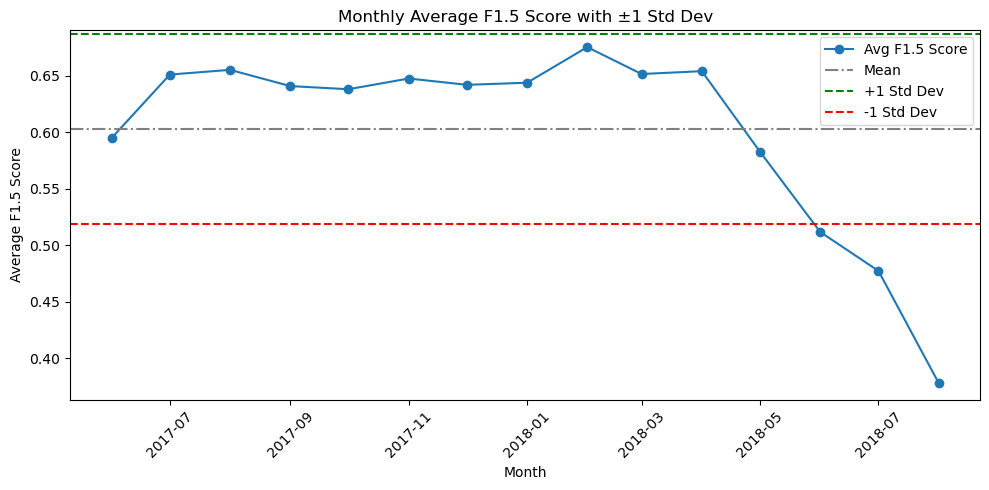

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

monthly_avg['snapshot_date'] = pd.to_datetime(monthly_avg['snapshot_date'])

# Calculate mean and std dev
mean_score = monthly_avg['f1_5_score'].mean()
std_score = monthly_avg['f1_5_score'].std()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg['snapshot_date'], monthly_avg['f1_5_score'], marker='o', label='Avg F1.5 Score')
plt.axhline(mean_score, color='gray', linestyle='-.', label='Mean')
plt.axhline(mean_score + std_score, color='green', linestyle='--', label='+1 Std Dev')
plt.axhline(mean_score - std_score, color='red', linestyle='--', label='-1 Std Dev')

plt.title('Monthly Average F1.5 Score with ±1 Std Dev')
plt.xlabel('Month')
plt.ylabel('Average F1.5 Score')
#plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import datetime
import os

start_date = datetime.date(2017, 1, 1)
end_date = datetime.date(2018, 10, 1)

model = 'reg'

for i in range((end_date - start_date).days + 1):
    day = start_date + datetime.timedelta(days=i)
    day_str = day.strftime("%Y-%m-%d")
    cmd = f'python model_monitoring.py --snapshotdate "{day_str}" --model "{model}"'
    print(f'execute command: {cmd}')
    os.system(cmd)